# Lab - Dimension Reduction
## Introduction to Matrix Completion

---

**Course:** Dimension Reduction 

**Authors:** Fathnelle & Mamadou

**Date:** February 2026  

---

---
## Introduction & Dataset

In [1]:
# imports
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd

In [2]:

data = pd.read_csv('./ml-latest-small/ratings.csv')
print(data.head())
print(data.info())
print("Total numbers of ratings :", len(data))
print("Numbers of users:", data["userId"].nunique())
print("Numbers of movies :", data["movieId"].nunique())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
Total numbers of ratings : 100836
Numbers of users: 610
Numbers of movies : 9724


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


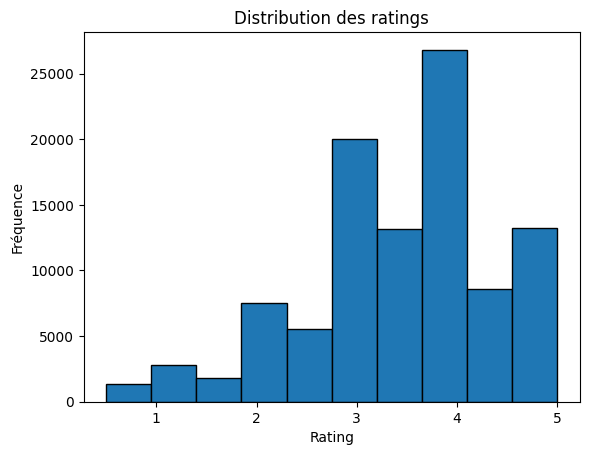

In [3]:
# descriptive statistics of the ratings
print(data["rating"].describe())

plt.hist(data["rating"], bins=10, edgecolor='black')
plt.title("Distribution des ratings")
plt.xlabel("Rating")
plt.ylabel("Fréquence")
plt.show()


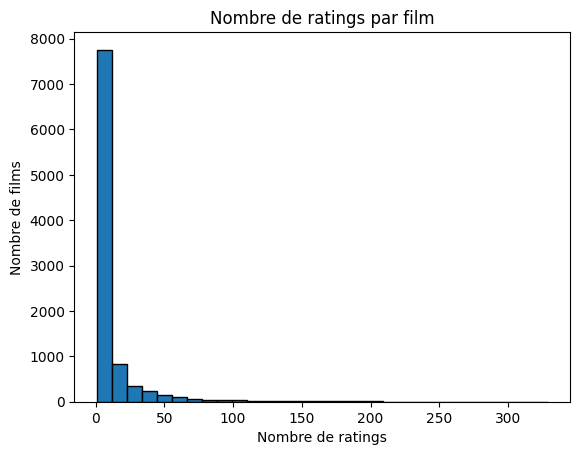

In [4]:
# numbers of ratings per movie

ratings_per_movie = data.groupby("movieId")["userId"].count()

plt.hist(ratings_per_movie, bins=30, edgecolor='black')
plt.title("Nombre de ratings par film")
plt.xlabel("Nombre de ratings")
plt.ylabel("Nombre de films")
plt.show()


### Building of the matrix user x movie 

In [5]:

user_ids = data["userId"].astype("category").cat.codes
movie_ids = data["movieId"].astype("category").cat.codes

ratings = data["rating"].values

n_users = user_ids.nunique()
n_movies = movie_ids.nunique()

Y = coo_matrix((ratings, (user_ids, movie_ids)), shape=(n_users, n_movies))

print(" Shape of the matrix :", Y.shape)

# Rate of sparsity
total_entries = n_users * n_movies
observed_entries = len(ratings)

sparsity = 1 - observed_entries / total_entries

print("Rate sparsity :", sparsity)

 Shape of the matrix : (610, 9724)
Rate sparsity : 0.9830003169443864


We can notice that 610*9724 = 6 millions but we just have 100k values available. The MovieLens dataset is highly sparse, with more than 98% missing entries. The singular values exhibit a fast decay, suggesting that the rating matrix can be well approximated by a low-rank structure. This justifies the use of low-rank matrix completion algorithms such as SVP, SVT and ADMiRA.

##  Plotting of the singular values of the matrix Y

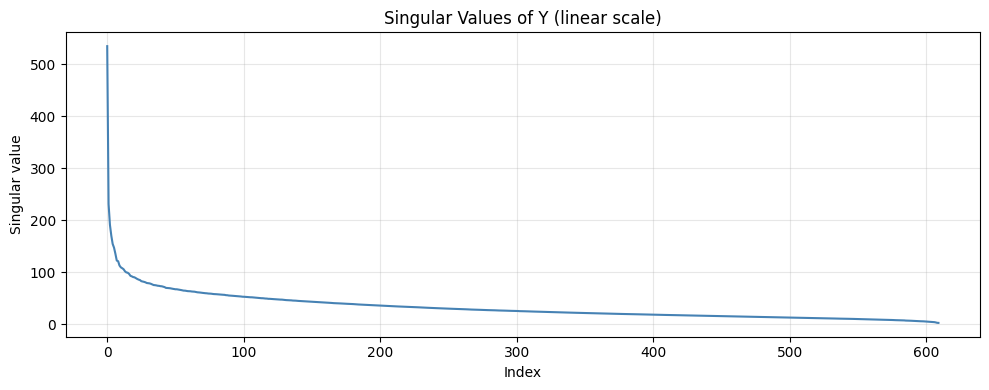

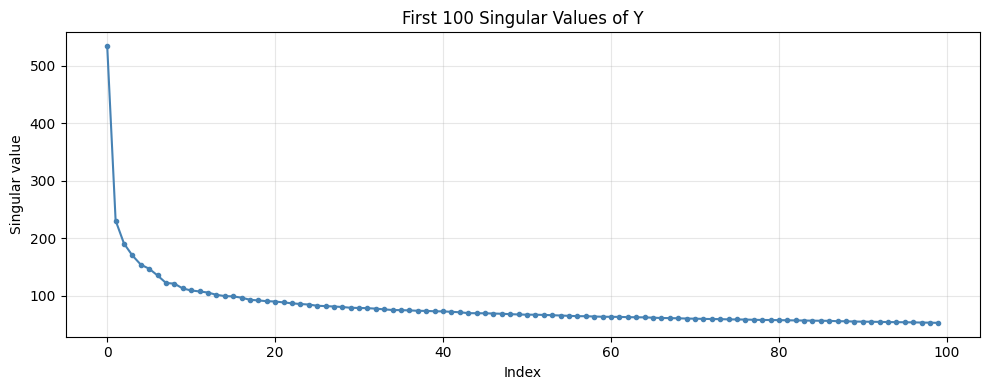

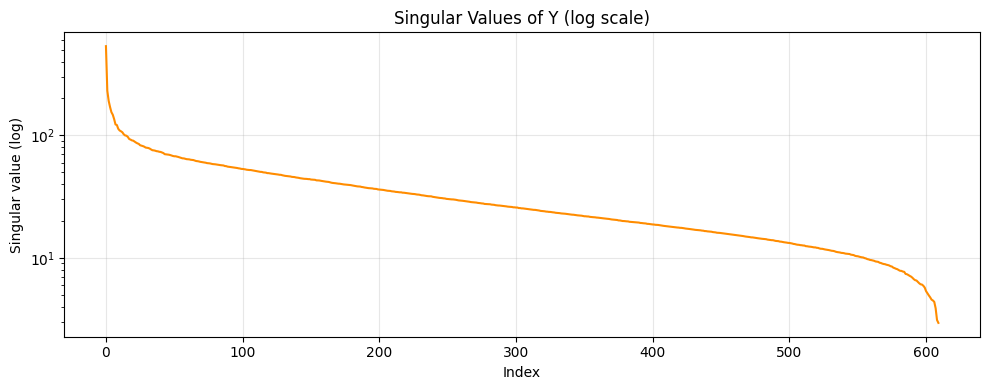

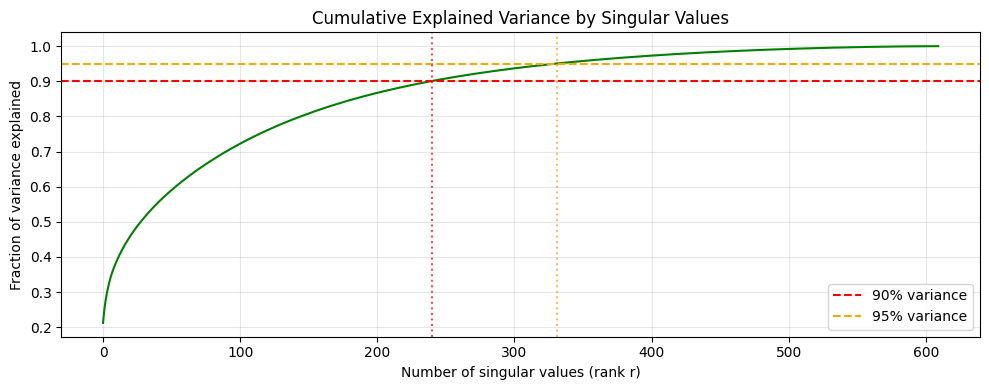

Rank needed to explain 90% of variance : r = 240
Rank needed to explain 95% of variance : r = 331
Total number of singular values         : 610
Largest singular value  : 534.42
Smallest singular value : 2.947207


In [6]:
### 5- Plot the singular values of the matrix Y

# Convert sparse matrix to dense for SVD
Y_dense = Y.toarray().astype(np.float64)

# Compute SVD (full matrices=False for efficiency)
U, sigma, Vt = svd(Y_dense, full_matrices=False)

# Plot 1: All singular values (linear scale) 
plt.figure(figsize=(10, 4))
plt.plot(sigma, color='steelblue', linewidth=1.5)
plt.title("Singular Values of Y (linear scale)")
plt.xlabel("Index")
plt.ylabel("Singular value")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: First 100 singular values (zoom)
plt.figure(figsize=(10, 4))
plt.plot(sigma[:100], marker='o', markersize=3, color='steelblue', linewidth=1.5)
plt.title("First 100 Singular Values of Y")
plt.xlabel("Index")
plt.ylabel("Singular value")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Log scale to reveal the decay structure
plt.figure(figsize=(10, 4))
plt.semilogy(sigma, color='darkorange', linewidth=1.5)
plt.title("Singular Values of Y (log scale)")
plt.xlabel("Index")
plt.ylabel("Singular value (log)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Explained variance (cumulative energy)
energy = np.cumsum(sigma**2) / np.sum(sigma**2)
plt.figure(figsize=(10, 4))
plt.plot(energy, color='green', linewidth=1.5)
plt.axhline(0.9, color='red', linestyle='--', label='90% variance')
plt.axhline(0.95, color='orange', linestyle='--', label='95% variance')
r90  = np.searchsorted(energy, 0.90) + 1
r95  = np.searchsorted(energy, 0.95) + 1
plt.axvline(r90,  color='red',    linestyle=':', alpha=0.7)
plt.axvline(r95,  color='orange', linestyle=':', alpha=0.7)
plt.title("Cumulative Explained Variance by Singular Values")
plt.xlabel("Number of singular values (rank r)")
plt.ylabel("Fraction of variance explained")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Rank needed to explain 90% of variance : r = {r90}")
print(f"Rank needed to explain 95% of variance : r = {r95}")
print(f"Total number of singular values         : {len(sigma)}")
print(f"Largest singular value  : {sigma[0]:.2f}")
print(f"Smallest singular value : {sigma[-1]:.6f}")

The singular values of Y exhibit a very fast initial decay: a small number of large singular values capture most of the variance, while the remaining ones are nearly negligible. On the log-scale plot this appears as an approximately linear slope, confirming an exponential decay.

---
## Algorithms for Matrix Completion 

Now we are comparing each matrix completion algorithm to a sparse regression method. SVP (Singular Value Projection) works like this: we take a gradient step, then we project onto matrices of rank ≤ r. That means: keep only the top r singular values. This is very similar to Iterative Hard Thresholding (IHT). In IHT, we take a gradient step, keep only the largest k coefficients
IHT → keeps largest coefficients
SVP → keeps largest singular values

They are conceptually the same idea.

### Singular Value Projection

In [ ]:
### SVP algorithm

def svd_r(M, r):
    """
    Truncated SVD: keeps only the r largest singular values.
    
    Parameters:
        M : dense matrix (n x m)
        r : target rank (number of singular values to keep)
    
    Returns:
        U_r, Sigma_r, Vt_r : truncated SVD components
        M_r : low-rank reconstruction = U_r @ diag(Sigma_r) @ Vt_r
    """
    U, sigma, Vt = svd(M, full_matrices=False)
    # Keep only the first r columns/rows
    U_r     = U[:, :r]
    sigma_r = sigma[:r]
    Vt_r    = Vt[:r, :]
    M_r = U_r @ np.diag(sigma_r) @ Vt_r
    return U_r, sigma_r, Vt_r, M_r


def project_S(M, mask):
    """
    Projection operator onto S: computes X^S
    Keeps only the observed entries (mask=1), sets 0 elsewhere.
    
    This is the equivalent of Y^S in the paper:
        X^S_ij = X_ij if (i,j) in S, 0 otherwise
    """
    return M * mask


def svp(Y_S, mask, r, max_iter=200, tol=1e-4, verbose=True):
    """
    Singular Value Projection (SVP) — Algorithm 1 from the paper.

    Core idea:
    ----------
    We seek X of rank <= r such that X^S is as close as possible to Y^S.
    At each iteration:
      1. Gradient descent step : X_{t+1/2} = X_t + (Y^S - X_t^S)
         -> We correct X_t only on the observed entries in S.
         -> This is a gradient step with learning rate eta=1 on the loss ||X^S - Y^S||²
      2. Projection onto rank r : X_{t+1} = SVD_r(X_{t+1/2})
         -> We project the result onto the set of matrices of rank <= r
         -> This is the "hard thresholding" on singular values
         -> Analogous to IHT but in the matrix setting

    Parameters:
    -----------
        Y_S      : sparse rating matrix (n x m), zeros for unobserved entries
        mask     : binary mask (1 if observed, 0 otherwise), same shape as Y_S
        r        : target rank
        max_iter : maximum number of iterations
        tol      : stopping criterion on the relative change of the loss
        verbose  : prints the loss every 20 steps

    Returns:
    --------
        X        : completed matrix of rank r
        losses   : history of the loss ||X^S - Y^S||_F² at each iteration
    """

    n, m = Y_S.shape
    losses = []

    # --- Step 1: Initialization X_0 = 0 (line 1 of the algorithm) ---
    X = np.zeros((n, m))

    for t in range(max_iter):

        # --- Step 2: Gradient step (line 3 of the algorithm) ---
        # Residual computed only on the observed entries S
        residual = Y_S - project_S(X, mask)   # = Y^S - X_t^S
        X_half   = X + residual                # = X_t + (Y^S - X_t^S)
        # Note: on unobserved entries, residual=0 so X_half = X
        # On observed entries, we "push" X towards Y

        # --- Step 3: Truncated SVD at rank r (lines 4-5 of the algorithm) ---
        # We project X_{t+1/2} onto the set {matrices of rank <= r}
        # The best rank-r approximation of a matrix M is given by SVD_r(M)
        # (Eckart-Young theorem)
        _, _, _, X_new = svd_r(X_half, r)

        # --- Loss computation on S: ||X^S - Y^S||_F² ---
        loss = np.sum((project_S(X_new, mask) - Y_S) ** 2)
        losses.append(loss)

        if verbose and t % 20 == 0:
            print(f"Iter {t:4d} | Loss (on S): {loss:.4f}")

        # --- Stopping criterion: relative change of the loss ---
        if t > 0 and abs(losses[-2] - losses[-1]) / (losses[-2] + 1e-10) < tol:
            print(f"Convergence reached at iteration {t}")
            break

        X = X_new

    return X, losses


# Data preparation

# Dense matrix of observed ratings Y^S (zeros = unobserved)
Y_S  = Y.toarray().astype(np.float64)

# Binary mask: 1 if the rating exists, 0 otherwise
mask = (Y_S != 0).astype(np.float64)

# Running SVP 

r = 20   # target rank — to be tuned (see singular value analysis)

X_svp, losses_svp = svp(Y_S, mask, r=r, max_iter=200, tol=1e-4, verbose=True)

# Convergence plot

plt.figure(figsize=(8, 4))
plt.plot(losses_svp, color='steelblue', linewidth=2)
plt.title(f"SVP — Loss convergence (r={r})")
plt.xlabel("Iteration")
plt.ylabel(r"$\|X^S - Y^S\|_F^2$")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#  Evaluation: RMSE on observed entries

observed_idx = mask == 1
rmse_train   = np.sqrt(np.mean((X_svp[observed_idx] - Y_S[observed_idx])**2))
print(f"\nRMSE on S (train) for r={r}: {rmse_train:.4f}")

# ── Sensitivity to rank r ─────────────────────────────────────────────────────

ranks        = [5, 10, 20, 50, 100]
rmse_list    = []
final_losses = []

for r_test in ranks:
    X_test, losses_test = svp(Y_S, mask, r=r_test, max_iter=100,
                               tol=1e-4, verbose=False)
    rmse = np.sqrt(np.mean((X_test[observed_idx] - Y_S[observed_idx])**2))
    rmse_list.append(rmse)
    final_losses.append(losses_test[-1])
    print(f"r={r_test:4d} | RMSE={rmse:.4f} | Final loss={losses_test[-1]:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(ranks, rmse_list, marker='o', color='tomato', linewidth=2)
plt.title("RMSE on S as a function of rank r (SVP)")
plt.xlabel("Rank r")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Iter    0 | Loss (on S): 564559.0280
Iter   20 | Loss (on S): 67677.6655
Iter   40 | Loss (on S): 40032.3273


SVP alternates between two operations until convergence: a gradient step to fit the observed data, followed by a projection onto the set of matrices of rank ≤ r to impose the low-rank constraint.